<a href="https://colab.research.google.com/github/sophnit/DDPG_PEN/blob/main/Noise_OUTSIDE_DDPG_PEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import environment

In [ ]:

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
!pip install gymnasium

import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# 2 Environment Initialize



In [ ]:
# Specify the `render_mode` parameter to show the attempts of the agent in a pop up window.
env = gym.make("Pendulum-v1", render_mode="human")

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


# 3 Add Noise


# 4. Buffer Class for Experienced Replay


In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=500000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') observation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -keras.ops.mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)


# 5. Actor and Critic Classes


In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through separate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model

# Parameter Space Noise


In [ ]:
import tensorflow as tf
import numpy as np

def apply_parameter_space_noise(actor_model, noise_stddev):
    # Create a perturbed copy of the actor model
    perturbed_model = tf.keras.models.clone_model(actor_model)
    perturbed_model.set_weights(actor_model.get_weights())  # Copy original weights

    # Add noise to each layer's weights
    original_weights = actor_model.get_weights()
    perturbed_weights = []
    for weight in original_weights:
        noise = np.random.normal(scale=noise_stddev, size=weight.shape)
        perturbed_weights.append(weight + noise)  # Add noise to each layer's weights

    # Update the perturbed model with the noisy weights
    perturbed_model.set_weights(perturbed_weights)

    return perturbed_model

# 5 Policy


In [ ]:
def policy(state, perturbed_actor_model):
    # Get actions from the perturbed actor model
    sampled_actions = tf.squeeze(perturbed_actor_model(state)).numpy()

    # Ensure actions are within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


# 6 Training Parameters

In [ ]:
std_dev = 0.2


actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
actor_lr = 0.0005
critic_lr = 0.0005

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)

total_episodes = 150
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.002

buffer = Buffer(10000, 64)

start_episode = 100 #reset for average converging value
end_episode = 150

T = "T13" #Reset for trial number

 # Perturb the actor model weights for this episode
noise_stddev = 0.005  # Standard deviation for parameter space noise

# 7. Training Loop

Episode * 0 * Avg Reward is ==> -970.0350003581582
Episode * 10 * Avg Reward is ==> -1204.144423253346
Episode * 20 * Avg Reward is ==> -1182.0714980794219
Episode * 30 * Avg Reward is ==> -810.7537685318114
Episode * 40 * Avg Reward is ==> -679.1731559363137
Episode * 50 * Avg Reward is ==> -329.76357992630244
Episode * 60 * Avg Reward is ==> -509.45676073593006
Episode * 70 * Avg Reward is ==> -491.3525242862118
Episode * 80 * Avg Reward is ==> -158.4578927913967
Episode * 90 * Avg Reward is ==> -135.77441095697662
Episode * 100 * Avg Reward is ==> -290.50776511098644
Episode * 110 * Avg Reward is ==> -102.48442729428716
Episode * 120 * Avg Reward is ==> -159.08695039994333
Episode * 130 * Avg Reward is ==> -190.79911526626012
Episode * 140 * Avg Reward is ==> -179.91706728847737

Training completed in 1094.63 seconds (18.24 minutes).


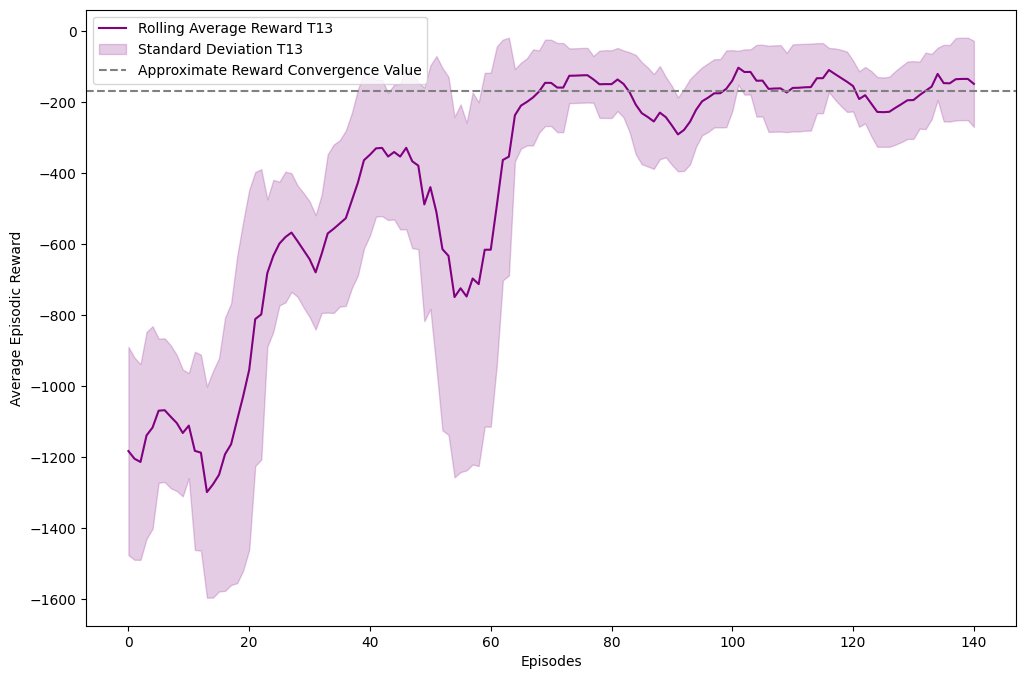

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time  # For measuring execution time

start_time = time.time()

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Training loop
for ep in range(total_episodes):
    prev_state, _ = env.reset()
    episodic_reward = 0

    # Perturb the actor model weights for this episode
    #noise_stddev = 0.1  # Standard deviation for parameter space noise
    perturbed_actor_model = apply_parameter_space_noise(actor_model, noise_stddev)

    while True:
        # Expand state dimensions for the actor model
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), axis=0)

        # Get action from the perturbed actor model
        action = policy(tf_prev_state, perturbed_actor_model)

        # Receive next state, reward, and done signal from the environment
        state, reward, done, truncated, _ = env.step(action)

        # Store the transition in the replay buffer
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        # Learn from the replay buffer
        buffer.learn()

        # Update target networks
        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode if done or truncated
        if done or truncated:
            break

        # Update previous state
        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 10 episodes
    avg_reward = np.mean(ep_reward_list[-10:])
    avg_reward_list.append(avg_reward)
    if ep % 10 == 0:
        print(f"Episode * {ep} * Avg Reward is ==> {avg_reward}")

# End the timer
end_time = time.time()

# Calculate and print the total time taken
total_time = end_time - start_time
print(f"\nTraining completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes).")

# Calculate rolling mean (window size = 10)
window_size = 10
rolling_mean = np.convolve(ep_reward_list, np.ones(window_size)/window_size, mode='valid')

# Calculate rolling standard deviation for the same window
rolling_std = np.array([
    np.std(ep_reward_list[i:i+window_size])
    for i in range(len(ep_reward_list) - window_size + 1)
])

# Adjust episodes to match rolling_mean and rolling_std
episodes = np.arange(len(rolling_mean))

# Set the figure size (width, height) in inches
plt.figure(figsize=(12, 8))  # Adjust the size as per your preference

# Plot the rolling mean
plt.plot(episodes, rolling_mean, color="purple", label=f"Rolling Average Reward {T}")

# Plot the standard deviation as a shaded region
plt.fill_between(
    episodes,
    rolling_mean - rolling_std,
    rolling_mean + rolling_std,
    color="purple",
    alpha=0.2,
    label=f"Standard Deviation {T}",
)

# Add the horizontal dotted line at the average reward from episode 55 to 200

# Calculate the average reward in this range
avg_reward_range = np.mean(avg_reward_list[start_episode:end_episode])
plt.axhline(avg_reward_range, color='grey', linestyle='--', label="Approximate Reward Convergence Value")


# Add labels, title, and legend
plt.xlabel("Episodes")
plt.ylabel("Average Episodic Reward")
plt.legend(loc="best")

# Display the plot
plt.show()

In [ ]:
 np.mean(avg_reward_list[start_episode:end_episode])

-168.65902696249003

# 7. Save the weights

In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.weights.h5")
critic_model.save_weights("pendulum_critic.weights.h5")

target_actor.save_weights("pendulum_target_actor.weights.h5")
target_critic.save_weights("pendulum_target_critic.weights.h5")

# New Section